In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split



from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization

from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score

#### 이미 전처리해서 중복 등을 제거한 좋은 데이터로 시작
각 클래스는 정수인코딩 되어있고   
협박 대화 = 0,  
갈취 대화 = 1,  
직장 내 괴롭힘 대화 = 2,  
기타 괴롭힘 대화 = 3,  
일반 = 4   

In [2]:
# train 데이터 로드
# train_data = pd.read_csv("C:/Users/양자/Desktop/Hun_Works/AIFFEL_DLthon/DLThon01/CHYeom/data/train.csv")
# 증강된 데이터 쓰기
train_data = pd.read_csv("C:/Users/양자/Desktop/Hun_Works/AIFFEL_DLthon/DLThon01/CHYeom/data/augmented_train.csv")
print('훈련용 텍스트 개수 :',len(train_data))
print(train_data['class'].unique())

훈련용 텍스트 개수 : 14364
[0 3 1 2 4]


In [3]:
# 텍스트 길이 계산
train_data['text_length'] = train_data['conversation'].astype(str).apply(len)

# 길이 통계 출력
print("훈련용 텍스트 개수:", len(train_data))
print("클래스 종류:", train_data['class'].unique())

print("텍스트 길이 통계:")
print("최소 길이:", train_data['text_length'].min())
print("최대 길이:", train_data['text_length'].max())
print("평균 길이:", train_data['text_length'].mean())
print("중앙값:", train_data['text_length'].median())
print("표준 편차:", train_data['text_length'].std())

# 길이 분포 히스토그램 시각화
import matplotlib.pyplot as plt

훈련용 텍스트 개수: 14364
클래스 종류: [0 3 1 2 4]
텍스트 길이 통계:
최소 길이: 34
최대 길이: 912
평균 길이: 203.71553884711778
중앙값: 181.0
표준 편차: 103.78763608113039


In [4]:
tokenizer = Tokenizer(num_words=10000)

In [5]:
tokenizer.fit_on_texts(train_data['conversation'])

max_len = int(217 + 1.5 * 108) # 평균 + 1.5 * 표준편차 한 것 

train_X = tokenizer.texts_to_sequences(train_data['conversation'])
train_X = pad_sequences(train_X, maxlen=max_len, padding='pre')
train_y = train_data['class'].values

In [6]:
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.2, random_state=42)

In [7]:
print(f"training data size: {len(train_X)}")
print(f"validation data size: {len(val_X)}")

training data size: 11491
validation data size: 2873


# LSTM 모델 구성하기

In [8]:
vocab_size = 10000 # sqrt(10000) = 100
embedding_dim = 128

In [9]:
model = Sequential()

model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
          
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(32))
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(5, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 379, 128)          1280000   
                                                                 
 lstm (LSTM)                 (None, 379, 128)          131584    
                                                                 
 dropout (Dropout)           (None, 379, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 379, 64)           49408     
                                                                 
 dropout_1 (Dropout)         (None, 379, 64)           0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0

In [10]:
# 모델 컴파일
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [11]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [12]:
history = model.fit(
    train_X, train_y,
    batch_size=64,
    epochs=10,
    validation_data=(val_X, val_y),
    callbacks=[es]
)

Epoch 1/10
180/180 [==============================] - 28s 118ms/step - loss: 0.8933 - accuracy: 0.6277 - val_loss: 0.8950 - val_accuracy: 0.8653
Epoch 2/10
180/180 [==============================] - 20s 109ms/step - loss: 0.2590 - accuracy: 0.9177 - val_loss: 0.2504 - val_accuracy: 0.9158
Epoch 3/10
180/180 [==============================] - 20s 111ms/step - loss: 0.1092 - accuracy: 0.9685 - val_loss: 0.1447 - val_accuracy: 0.9589
Epoch 4/10
180/180 [==============================] - 20s 109ms/step - loss: 0.0476 - accuracy: 0.9880 - val_loss: 0.1429 - val_accuracy: 0.9676
Epoch 5/10
180/180 [==============================] - 21s 115ms/step - loss: 0.0427 - accuracy: 0.9905 - val_loss: 0.1476 - val_accuracy: 0.9655
Epoch 6/10
180/180 [==============================] - 20s 112ms/step - loss: 0.0329 - accuracy: 0.9917 - val_loss: 0.1521 - val_accuracy: 0.9676


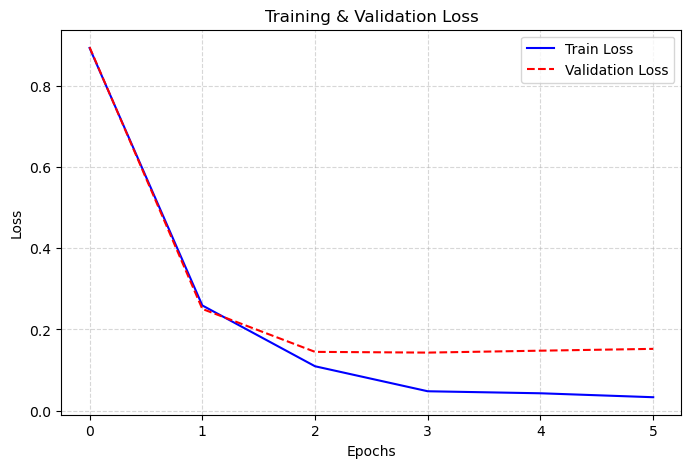

In [13]:
# 손실 그래프
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label="Train Loss", color='blue')
plt.plot(history.history['val_loss'], label="Validation Loss", color='red', linestyle="dashed")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


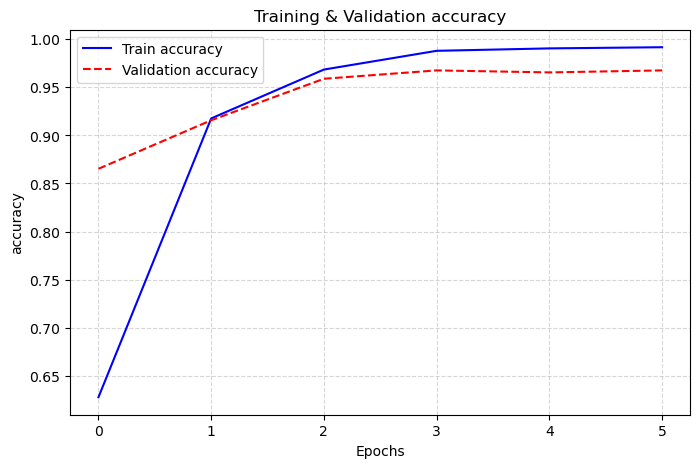

In [14]:
# 정확도 그래프
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label="Train accuracy", color='blue')
plt.plot(history.history['val_accuracy'], label="Validation accuracy", color='red', linestyle="dashed")

plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.title("Training & Validation accuracy")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


In [15]:
print("훈련 정확도: %.4f" % (model.evaluate(train_X, train_y)[1]))

360/360 [==============================] - 15s 42ms/step - loss: 0.0175 - accuracy: 0.9952
훈련 정확도: 0.9952


In [16]:
# 모델을 사용하여 예측 수행
val_predictions = np.argmax(model.predict(val_X), axis=-1)

90/90 [==============================] - 5s 41ms/step


In [17]:
# f1 score
f1 = f1_score(val_y, val_predictions, average='macro')
print(f"F1 Score: {f1}\n")

F1 Score: 0.9673853839018559



In [18]:
# classification report
report = classification_report(val_y, val_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.91      0.94       524
           1       0.94      0.98      0.96       550
           2       0.97      0.99      0.98       628
           3       0.95      0.96      0.96       632
           4       1.00      1.00      1.00       539

    accuracy                           0.97      2873
   macro avg       0.97      0.97      0.97      2873
weighted avg       0.97      0.97      0.97      2873



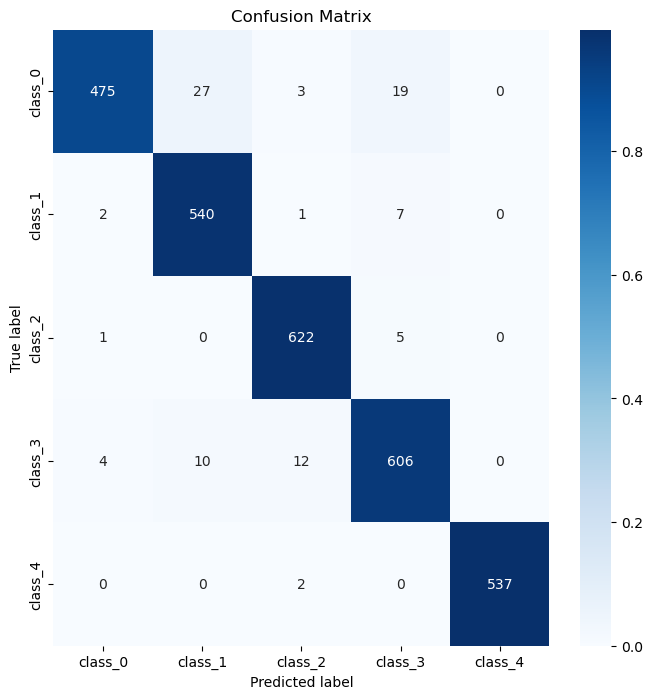

In [19]:
# confusion matrix 시각화
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm_norm, annot=cm, fmt='g', cmap=cmap,
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

# 협박, 갈취, 직장, 기타, 일반
classes = ["class_0", "class_1", "class_2", "class_3", "class_4"]
plot_confusion_matrix(val_y, val_predictions, classes)

In [20]:
def class_predict(sentence):
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=max_len)

    score = model.predict(sentence)[0]

    class_names = ['협박', '갈취', '직장 내 괴롭힘', '기타 괴롭힘', '일반']
    max_score_index = np.argmax(score)
    predicted_class = class_names[max_score_index]
    probability = score[max_score_index] * 100  

    print(f"{score * 100}%")
    print("해당 문장은 {:.2f}%의 확률로 '{}'!".format(probability, predicted_class))

In [42]:
class_predict("회사에서 일 안하고 대체 뭐해?  김 대리 같은 사람들이 있으니까 우리 회사가 이 모양 이 꼴 아니야")

1/1 [==============================] - 0s 72ms/step
[1.1004999e-04 2.2360880e-04 9.9999001e+01 3.7089060e-04 2.9878932e-04]%
해당 문장은 100.00%의 확률로 '직장 내 괴롭힘'!


In [40]:
class_predict("오늘 뭐 했어? 나는 김치 볶음밥 먹었어 삼겹살도 맛있다 사랑해 잘 자고 좋은 꿈 꿔 내일 봐")

1/1 [==============================] - 0s 64ms/step
[ 0.2300957   0.22831696  3.718369   11.0270605  84.79616   ]%
해당 문장은 84.80%의 확률로 '일반'!


In [36]:
class_predict("니가 그렇게 싸움을 잘 해? 나랑 맞짱뜨자")

1/1 [==============================] - 0s 73ms/step
[ 0.8298817  0.5625348  3.0456614 81.01042   14.551507 ]%
해당 문장은 81.01%의 확률로 '기타 괴롭힘'!


In [24]:
class_predict("아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나보네 그럼 취소할까요 아가씨 내 여기단골이니 담에 갖다줄께 저도 알바생이라 외상안됩니다 아따 누가 떼먹는다고 그러나 갖다준다고 안됩니다 자꾸이럼 경찰불러요 아가씨 담배피는교 그건 왜 물으세요 그람 아가씨 담배 한대만 빌립시다 내 지금 지갑도 잃어버리고 기분이 그래서 그러니 여기요  아따 주는김에 한개더 주면 되겠네")

1/1 [==============================] - 0s 48ms/step
[1.5628245e+00 9.8263329e+01 2.2507397e-02 1.4264101e-01 8.7065278e-03]%
해당 문장은 98.26%의 확률로 '갈취'!


In [25]:
test_df = pd.read_csv("C:/Users/양자/Desktop/Hun_Works/AIFFEL_DLthon/DLThon01/CHYeom/data/test.csv")

In [26]:
test_df.head()

,idx,text
0,t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...
1,t_001,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...
2,t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
3,t_003,이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 ...
4,t_004,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...


In [50]:
def get_class(sentence):
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=max_len)

    score = model.predict(sentence, verbose=0)[0]
    
    max_score_index = np.argmax(score)
    class_names = ['0', '1', '2', '3', '4']
    predicted_class = class_names[max_score_index]
    return predicted_class

In [51]:
test_df['target'] = test_df['text'].apply(get_class)

In [52]:
# 클래스별 개수 세기
class_counts = test_df['predicted_class'].value_counts()

# 결과 출력
print(class_counts)

predicted_class
3    156
2    133
1    115
0     80
4     16
Name: count, dtype: int64


In [53]:
test_df['text'][0]

'아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나보네 그럼 취소할까요 아가씨 내 여기단골이니 담에 갖다줄께 저도 알바생이라 외상안됩니다 아따 누가 떼먹는다고 그러나 갖다준다고 안됩니다 자꾸이럼 경찰불러요 아가씨 담배피는교 그건 왜 물으세요 그람 아가씨 담배 한대만 빌립시다 내 지금 지갑도 잃어버리고 기분이 그래서 그러니 여기요  아따 주는김에 한개더 주면 되겠네'

In [54]:
submission = test_df[['idx', 'target']].copy()

In [55]:
print(submission.head())

     idx target
0  t_000      1
1  t_001      2
2  t_002      2
3  t_003      3
4  t_004      3


In [56]:
submission.to_csv("C:/Users/양자/Desktop/Hun_Works/AIFFEL_DLthon/DLThon01/CHYeom/submission.csv", index=False)